# 1. Sucess Rate

In [4]:
import pandas as pd

# Define a dictionary to map player position codes to their descriptive names.
# These codes are standard identifiers for player positions in baseball.
player_pos_mapping = {
    1: 'pitcher',
    2: 'catcher',
    3: 'first baseman',
    4: 'second baseman',
    5: 'third baseman',
    6: 'shortstop',
    7: 'left field',
    8: 'center field',
    9: 'right field',
    10: 'batter',
    11: 'runner on first base',
    12: 'runner on second base',
    13: 'runner on third base',
    255: 'ball event with no player (e.g., ball bounce)'
}

# Define a dictionary to map event codes to their descriptive names.
# These codes are identifiers for various actions/events that occur during a baseball game.
event_code_mapping = {
    1: 'Pitch',
    2: 'Ball acquired',
    3: 'Throw (ball-in-play)',
    4: 'Ball hit into play',
    5: 'End of play',
    6: 'Pickoff throw',
    7: 'Ball acquired - unknown field position',
    8: 'Throw (ball-in-play) - unknown field position',
    9: 'Ball deflection',
    10: 'Ball deflection off of wall',
    11: 'Home run',
    16: 'ball bounce'
}

In [22]:
# Loading game events data and mapping event codes to their descriptive names.
game_events = pd.read_csv('/Users/guozichi/Desktop/smt_data_challenge_2023_new/game_events/game_events-1900_01_TeamKJ_TeamB.csv')
game_events['event_description'] = game_events['event_code'].map(event_code_mapping)
player_pos = pd.read_csv('/Users/guozichi/Desktop/smt_data_challenge_2023_new/player_pos/TeamB/player_pos-1900_TeamB/player_pos-1900_01_TeamKJ_TeamB.csv')

# Filtering out data specific to the shortstop position (Position code: 6).
shortstop_data = player_pos[player_pos['player_position'] == 6]

# Merging shortstop data with game events to get a consolidated view of each play and its corresponding event.
shortstop_data = pd.merge(shortstop_data, game_events[['play_id', 'event_description']], on='play_id')

def identify_successful_fielding_attempts(player_data):
    """
    Identify and count the successful fielding attempts by the player.
    
    Parameters:
    - player_data (DataFrame): DataFrame containing player's action data.
    
    Returns:
    - successful_attempts (int): Count of successful fielding attempts.
    - total_opportunities (int): Total opportunities for the player to make a play.
    """
    successful_attempts = 0
    total_opportunities = 0
    for play_id in player_data['play_id'].unique():
        play_data = player_data[player_data['play_id'] == play_id]
        
        # Sorting data by timestamp to analyze the sequence of events.
        play_data = play_data.sort_values(by='timestamp')
        
        # Extracting the sequence of events for each play.
        events_sequence = play_data['event_description'].tolist()
        
        # Identifying successful attempts and total opportunities based on the sequence of events.
        for i in range(len(events_sequence) - 1):
            if events_sequence[i] == 'Ball acquired' and events_sequence[i + 1] == 'Throw (ball-in-play)':
                successful_attempts += 1
            if events_sequence[i] == 'Ball acquired':
                total_opportunities += 1
    return successful_attempts, total_opportunities

# Calculating successful attempts and total opportunities for the shortstop.
shortstop_successful_attempts, shortstop_total_opportunities = identify_successful_fielding_attempts(shortstop_data)

# Computing the success rate. Guarding against division by zero.
shortstop_success_rate = shortstop_successful_attempts / shortstop_total_opportunities if shortstop_total_opportunities > 0 else 0

print("Successful Attempts:", shortstop_successful_attempts)
print("Total Opportunities:", shortstop_total_opportunities)
print("Success Rate:", shortstop_success_rate * 100, "%")  # Success rate as a percentage

Successful Attempts: 6036
Total Opportunities: 18684
Success Rate: 32.30571612074502 %


# 2. Distance 

In [ ]:
import pandas as pd
import numpy as np
import glob
import os

# Dictionaries that map numerical codes to descriptive names for game events and player positions.
event_code_mapping = {
    1: 'Pitch',
    2: 'Ball acquired',
    3: 'Throw (ball-in-play)',
    4: 'Ball hit into play',
    5: 'End of play',
    6: 'Pickoff throw',
    7: 'Ball acquired - unknown field position',
    8: 'Throw (ball-in-play) - unknown field position',
    9: 'Ball deflection',
    10: 'Ball deflection off of wall',
    11: 'Home run',
    16: 'ball bounce'
}

player_pos_mapping = {
    1: 'pitcher',
    2: 'catcher',
    3: 'first baseman',
    4: 'second baseman',
    5: 'third baseman',
    6: 'shortstop',
    7: 'left field',
    8: 'center field',
    9: 'right field',
    10: 'batter',
    11: 'runner on first base',
    12: 'runner on second base',
    13: 'runner on third base',
    255: 'ball event with no player (e.g., ball bounce)'
}

# Inverse dictionaries to translate descriptions back to numerical codes.
event_code_reverse_mapping = {v: k for k, v in event_code_mapping.items()}
player_pos_reverse_mapping = {v: k for k, v in player_pos_mapping.items()}

# Function to compute the Euclidean distance between two points on the field.
def calculate_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Function to analyze the shortstop's movement for a specific play in the game.
def track_shortstop_movement(play_id, ball_hit_events, player_pos, duration_seconds=5):
    ball_hit_timestamp = ball_hit_events[ball_hit_events['play_id'] == play_id].iloc[0]['timestamp']
    end_timestamp = ball_hit_timestamp + duration_seconds * 1000  # converting seconds to ms

    shortstop_positions = player_pos[
        (player_pos['play_id'] == play_id) & 
        (player_pos['player_position'] == player_pos_reverse_mapping['shortstop']) & 
        (player_pos['timestamp'] >= ball_hit_timestamp) & 
        (player_pos['timestamp'] <= end_timestamp)
    ]

    if not shortstop_positions.empty:
        initial_position = (shortstop_positions.iloc[0]['field_x'], shortstop_positions.iloc[0]['field_y'])
        final_position = (shortstop_positions.iloc[-1]['field_x'], shortstop_positions.iloc[-1]['field_y'])
        distance_moved = calculate_distance(initial_position[0], initial_position[1], final_position[0], final_position[1])
    else:
        initial_position = (None, None)
        final_position = (None, None)
        distance_moved = 0

    return {
        'play_id': play_id,
        'initial_position': initial_position,
        'final_position': final_position,
        'distance_moved (m)': distance_moved
    }

# Function to process the data for a single game, summarizing the shortstop's movements.
def process_game_data(player_file, ball_file):
    ball_pos = pd.read_csv(ball_file)
    player_pos = pd.read_csv(player_file)
    game_events_file = player_file.replace("player_pos", "game_events")
    game_events = pd.read_csv(game_events_file)
    
    ball_hit_events = game_events[game_events['event_code'] == event_code_reverse_mapping['Ball hit into play']]
    shortstop_movements = [track_shortstop_movement(play_id, ball_hit_events, player_pos) for play_id in ball_hit_events['play_id']]
    
    shortstop_movements_df = pd.DataFrame(shortstop_movements)
    median_distance = shortstop_movements_df['distance_moved (m)'].median()
    q1_distance = shortstop_movements_df['distance_moved (m)'].quantile(0.25)
    q3_distance = shortstop_movements_df['distance_moved (m)'].quantile(0.75)
    
    return median_distance, q1_distance, q3_distance

base_dir = "/Users/guozichi/Desktop/smt_data_challenge_2023_new/Team_A"

results = {}

# Loop to process each player position CSV file in the specified directory.
for player_file in glob.glob(os.path.join(base_dir, 'player_pos-*.csv')):
    game_id = os.path.basename(player_file).split('-')[1].split('.csv')[0]
    ball_file = os.path.join(base_dir, f'ball_pos-{game_id}.csv')
    
    if os.path.exists(ball_file):
        median_distance, q1_distance, q3_distance = process_game_data(player_file, ball_file)
        results[game_id] = {'median_distance': median_distance, 'q1_distance': q1_distance, 'q3_distance':q3_distance}

for game, metrics in results.items():
    print(f"{game}: median_distance: {metrics['median_distance']}, q1_distance: {metrics['q1_distance']}, q3_distance: {metrics['q3_distance']} ")

# 3. Range

In [23]:
import pandas as pd
import glob

# Function to calculate the fielding range for the shortstop during a given game.
# It computes the lateral (X) and depth (Y) range based on the player's movements.
def calculate_fielding_range(player_file, ball_file):
    player_df = pd.read_csv(player_file)
    
    # Filtering out the shortstop (Position code: 6)
    shortstop_df = player_df[player_df['player_position'] == 6]
    
    # Calculate the range in field_x and field_y
    x_range = shortstop_df['field_x'].max() - shortstop_df['field_x'].min()
    y_range = shortstop_df['field_y'].max() - shortstop_df['field_y'].min()
    
    return round(x_range, 2), round(y_range, 2)

results = {}

# Iterate over all player position files in the current directory.
# The files are assumed to follow a specific naming pattern.
for player_file in glob.glob('player_pos-*.csv'):
    game_id = player_file.split('-')[1].split('.csv')[0]
    ball_file = f'ball_pos-{game_id}.csv'
    
    x_range, y_range = calculate_fielding_range(player_file, ball_file)
    results[game_id] = {'X Range': x_range, 'Y Range': y_range}

# Display the computed fielding ranges for each game.
for game, ranges in results.items():
    print(f"{game}: X Range: {ranges['X Range']}, Y Range: {ranges['Y Range']}")

In [33]:
import pandas as pd

data = pd.read_csv("/Users/guozichi/Desktop/smt_data_challenge_2023_new/final_data.csv")   
data['    Success Rate'] = data['    Success Rate'].str.replace('%', '').astype(float) / 100

# compute the correlations
correlations = {
    "X Range vs Success Rate": data['X Range_x'].corr(data['    Success Rate']),
    "Y Range vs Success Rate": data['Y Range_x'].corr(data['    Success Rate']),
    "Median Distance vs Success Rate": data['median_distance'].corr(data['    Success Rate']),
    "Q1 Distance vs Success Rate": data['q1_distance'].corr(data['    Success Rate']),
    "Q3 Distance vs Success Rate": data['q3_distance'].corr(data['    Success Rate'])
}

# Print the correlations
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")


X Range vs Success Rate: 0.190
Y Range vs Success Rate: 0.278
Median Distance vs Success Rate: 0.242
Q1 Distance vs Success Rate: 0.060
Q3 Distance vs Success Rate: 0.338


## Figures

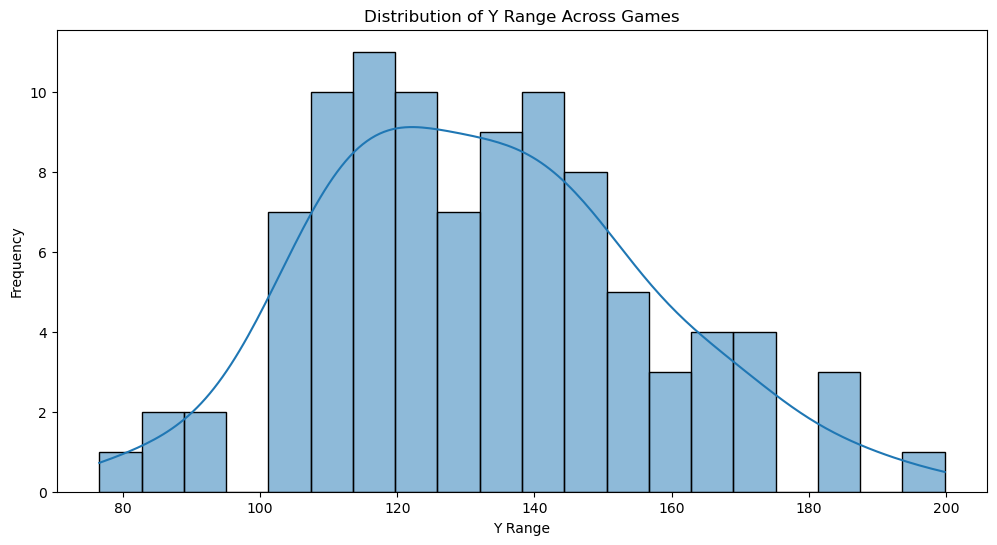

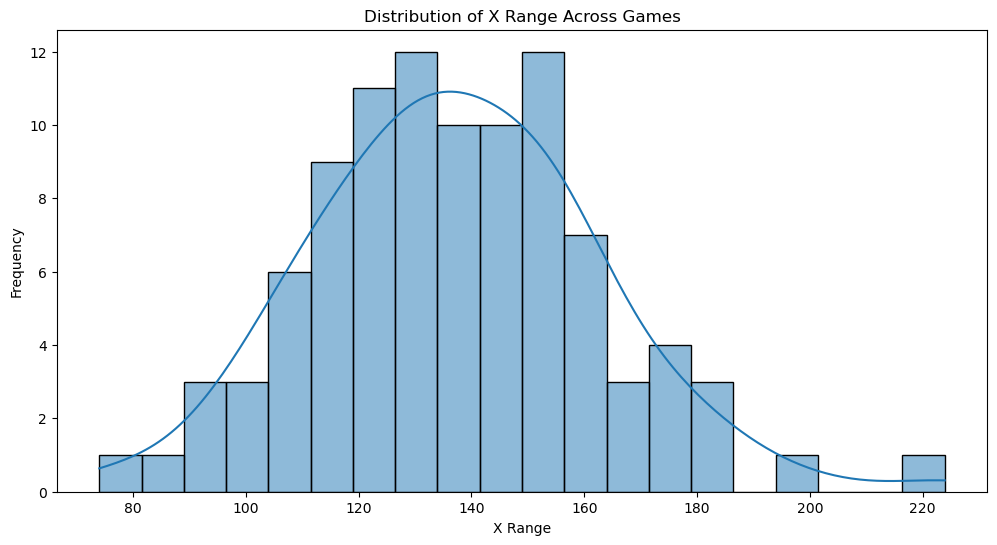

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = pd.read_csv("/Users/guozichi/Desktop/smt_data_challenge_2023_new/final_data.csv")  

plt.figure(figsize=(12, 6))
# Plotting a histogram of the 'Y Range_x' data column using Seaborn's histplot function.
# KDE (Kernel Density Estimate) line is added to the histogram for better visualization of data distribution.
sns.histplot(data['Y Range_x'], bins=20, kde=True)
plt.title('Distribution of Y Range Across Games')
plt.xlabel('Y Range')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(12, 6))
sns.histplot(data['X Range_x'], bins=20, kde=True)
plt.title('Distribution of X Range Across Games')
plt.xlabel('X Range')
plt.ylabel('Frequency')
plt.show()

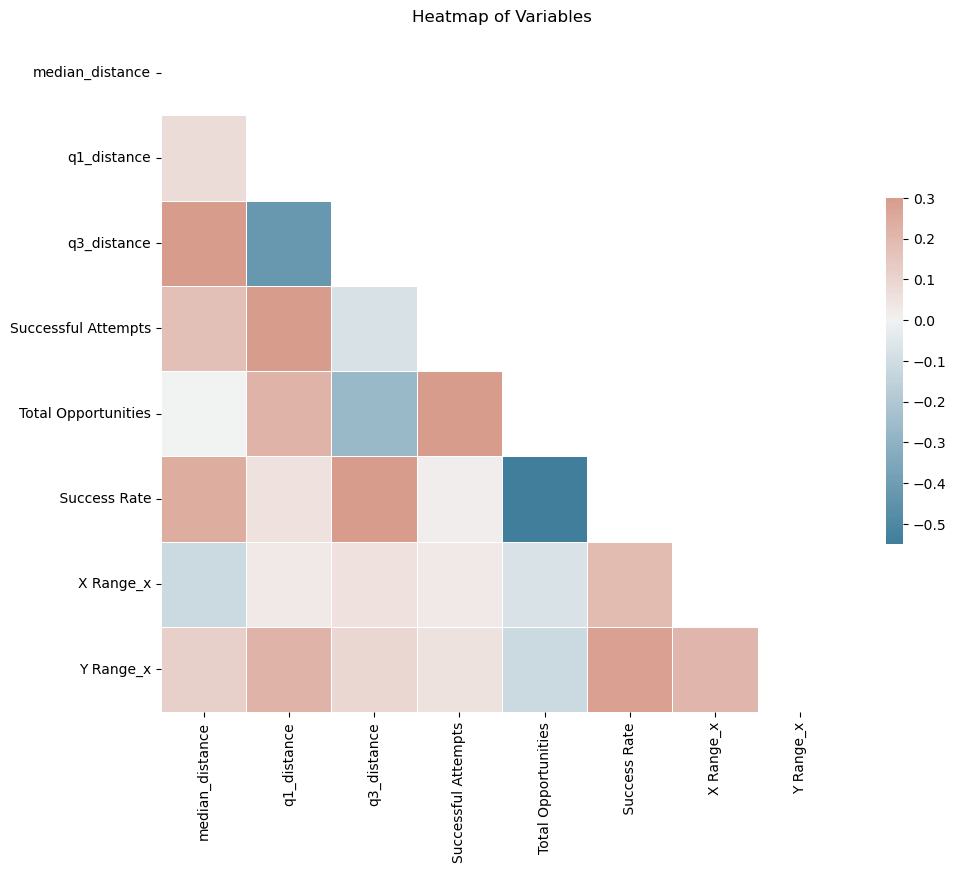

In [24]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/guozichi/Desktop/smt_data_challenge_2023_new/final_data.csv')

# Remove the '%' from the '    Success Rate' column and convert to float
df['    Success Rate'] = df['    Success Rate'].str.replace('%', '').astype(float)

# Display the first few rows of the cleaned dataframe
df.head()

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Heatmap of Variables')
plt.show()

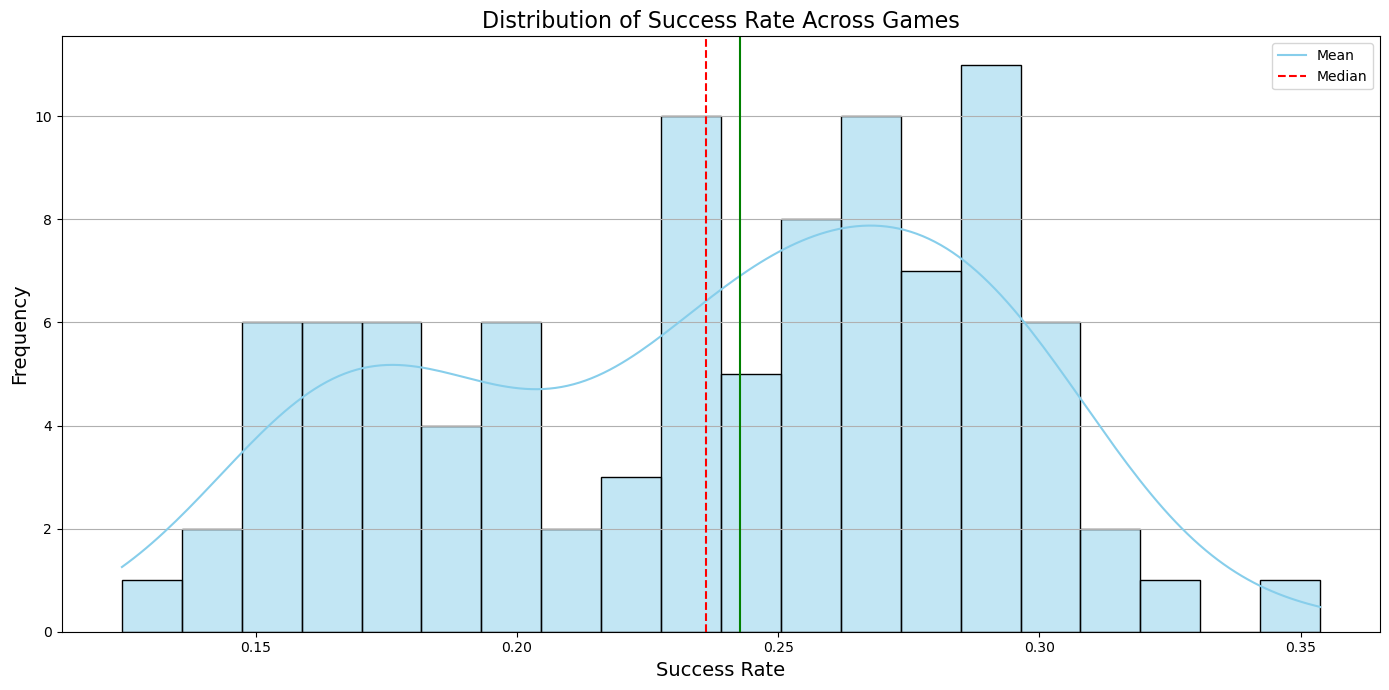

In [26]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset once more
data = pd.read_csv("/Users/guozichi/Desktop/smt_data_challenge_2023_new/final_data.csv")

# Converting the "    Success Rate" column to a numerical format by removing the '%' sign and converting to float
data['    Success Rate'] = data['    Success Rate'].str.rstrip('%').astype('float') / 100.0

# Plotting the distribution of Success Rate
plt.figure(figsize=(14, 7))
sns.histplot(data['    Success Rate'], bins=20, kde=True, color='skyblue')

# Annotating the plot with mean and median values
mean_success_rate = data['    Success Rate'].mean()
median_success_rate = data['    Success Rate'].median()
plt.axvline(mean_success_rate, color='r', linestyle='--')
plt.axvline(median_success_rate, color='g', linestyle='-')
plt.legend({'Mean':mean_success_rate, 'Median':median_success_rate})

# Adding titles and labels
plt.title('Distribution of Success Rate Across Games', fontsize=16)
plt.xlabel('Success Rate', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y')

# Displaying the plot
plt.tight_layout()
plt.show()

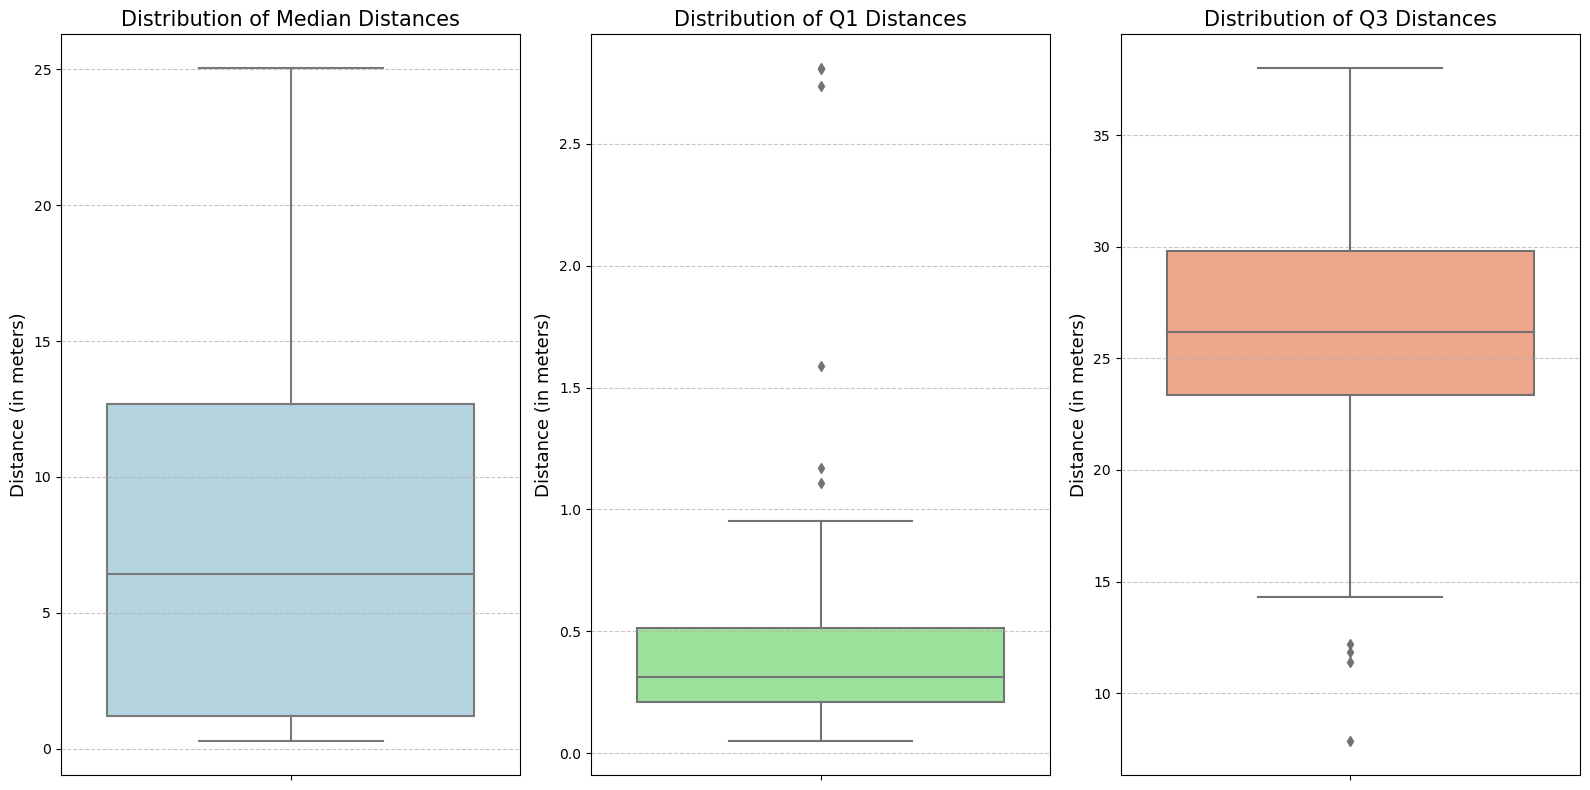

In [27]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset once more
data_updated = pd.read_csv("/Users/guozichi/Desktop/smt_data_challenge_2023_new/final_data.csv")

# Extracting the three metrics using the correct column names
median_distance = data_updated['median_distance']
q1_distance = data_updated['q1_distance']
q3_distance = data_updated['q3_distance']

# Plotting the distributions
plt.figure(figsize=(16, 8))

# Boxplot for Median Distance
plt.subplot(1, 3, 1)
sns.boxplot(y=median_distance, color='lightblue')
plt.title('Distribution of Median Distances', fontsize=15)
plt.ylabel('Distance (in meters)', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot for Q1 Distance
plt.subplot(1, 3, 2)
sns.boxplot(y=q1_distance, color='lightgreen')
plt.title('Distribution of Q1 Distances', fontsize=15)
plt.ylabel('Distance (in meters)', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Boxplot for Q3 Distance
plt.subplot(1, 3, 3)
sns.boxplot(y=q3_distance, color='lightsalmon')
plt.title('Distribution of Q3 Distances', fontsize=15)
plt.ylabel('Distance (in meters)', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjusting layout
plt.tight_layout()
plt.show()
